In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from data.datasets import get_dataloader
from models.models import PoseGRU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Data loaders
train_loader = get_dataloader("data/splits/train.npz", batch_size=32, shuffle=True)
val_loader = get_dataloader("data/splits/val.npz", batch_size=32, shuffle=False)
test_loader = get_dataloader("data/splits/test.npz", batch_size=32, shuffle=False)

# Loggign batch size
X_batch, y_batch = next(iter(train_loader))
print("Batch X:", X_batch.shape)
print("Batch y:", y_batch.shape)

Batch X: torch.Size([32, 30, 102])
Batch y: torch.Size([32])


In [3]:
# Model
input_dim = X_batch.shape[2]  
num_classes = len(torch.unique(y_batch))

model = PoseGRU(input_dim=input_dim, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [4]:
# Training
num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/20, Train Loss: 1.1458, Val Loss: 0.6754, Val Acc: 0.7349
Epoch 2/20, Train Loss: 0.4000, Val Loss: 0.2196, Val Acc: 0.9337
Epoch 3/20, Train Loss: 0.1095, Val Loss: 0.0883, Val Acc: 0.9849
Epoch 4/20, Train Loss: 0.0523, Val Loss: 0.0244, Val Acc: 0.9940
Epoch 5/20, Train Loss: 0.0069, Val Loss: 0.0044, Val Acc: 1.0000
Epoch 6/20, Train Loss: 0.0031, Val Loss: 0.0029, Val Acc: 1.0000
Epoch 7/20, Train Loss: 0.0022, Val Loss: 0.0022, Val Acc: 1.0000
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0018, Val Acc: 1.0000
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0015, Val Acc: 1.0000
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013, Val Acc: 1.0000
Epoch 11/20, Train Loss: 0.0009, Val Loss: 0.0011, Val Acc: 1.0000
Epoch 12/20, Train Loss: 0.0008, Val Loss: 0.0010, Val Acc: 1.0000
Epoch 13/20, Train Loss: 0.0007, Val Loss: 0.0009, Val Acc: 1.0000
Epoch 14/20, Train Loss: 0.0006, Val Loss: 0.0009, Val Acc: 1.0000
Epoch 15/20, Train Loss: 0.0005, Val Loss: 0.0008, Val Acc: 1.0000
Epoc

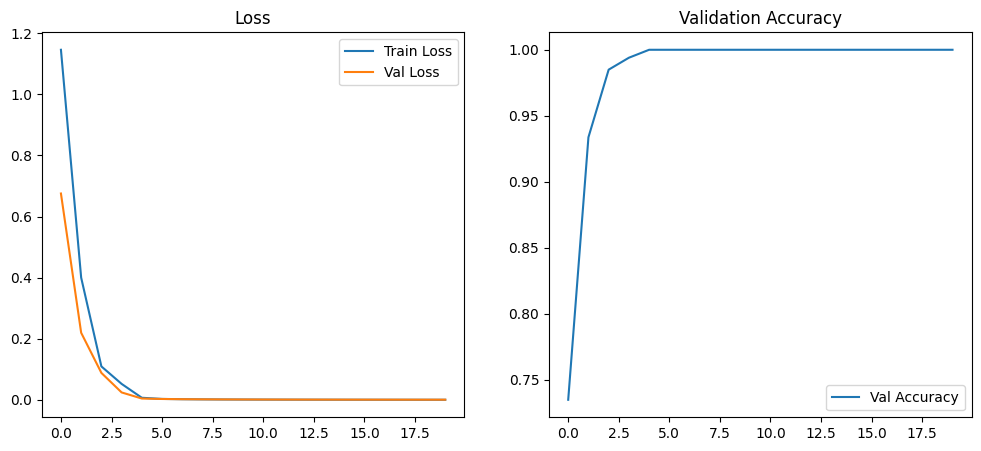

In [5]:
# Learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

Test Accuracy: 1.0


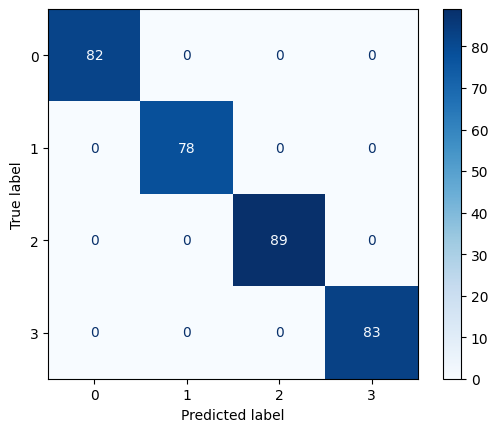

In [6]:
# Test 
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", acc)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

In [7]:
# Save model
torch.save(model.state_dict(), "models/pose_gru.pt")
print("Saved in trained_models/pose_gru.pt")

Saved in trained_models/pose_gru.pt
